# Comparing corpora media and parliamentary corpora with topic modeling

Comparing corpora with topic modeling is a well-known open challenge. One of the central problems is the difference in size of different corpora. That's why we tried oversampling (parliamentary speeches) and undersampling (news media articles) corpora - but they could help introducing distortions in our datasets. 

Hence, we decided to perform exploration based on specific events. We consider those dates in which we have many speeches and around the same number of articles from the same period. This period is February 2023, when the French pension reform was introduced in Parliament. Then we perform a single NMF model and implement the corpora comparison techinique based on doc-topic matrix.

In [1]:
import pandas as pd
import numpy as np

import spacy
nlp = spacy.load("fr_core_news_sm")
from spacy.lang.fr.stop_words import STOP_WORDS
import string 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns; sns.set_style("whitegrid")

from tqdm import tqdm
tqdm.pandas()

import datetime
import os

## Load data

### Parliament

In [2]:
# Import data from session on retraite and speeches mentioning retraite
df_title_retraite = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/Parliament/parl_corpus/parl_title_retraite.csv')
df_speech_retraite = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/Parliament/parl_corpus/parl_speech_retraite.csv')

# Merge data from session on retraite and speeches mentioning retraite
df_parl = pd.concat([df_title_retraite, df_speech_retraite])
df_parl = df_parl.dropna(subset='speech').drop_duplicates(subset='speech')

# Filter speeches from November 2022 onwards
df_parl['dateSeance'] = pd.to_datetime(df_parl['dateSeance'], format='%Y%m%d%H%M%S%f')
df_parl = df_parl[df_parl['dateSeance'] >= pd.to_datetime('2022-11-01')]
df_parl.shape

(1395, 15)

In [3]:
# Preprocess data
stopwords = set(STOP_WORDS)
custom_sw_parl = {'réforme','retraite','retrait','oui','no','avis','mme','monsieur','parole','pouvoir','faire','devoir','bien',
                  'falloir','prendre','aller','bon','vouloir','bien','favorable','sous','remettre'}
stopwords.update(custom_sw_parl)

def lemmatizer(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

def whitespace_remover(tokens):
    filtered_tokens = [token for token in tokens if token.strip() != '']
    filtered_tokens_newline = [token for token in filtered_tokens if token != '\n\n']
    return filtered_tokens_newline
    
def sw_remover(tokens):
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return filtered_tokens

def punct_remover(tokens):
    filtered_tokens = [token for token in tokens if not all(char in string.punctuation for char in token)]
    return filtered_tokens

def joiner(tokens):
    joined_tokens = ' '.join(tokens)
    return joined_tokens

In [4]:
# Create a new column 'TextLemmatized'
df_parl['TextLemmatized'] = df_parl['speech'].progress_apply(lemmatizer)
df_parl['TextProcessed'] = df_parl['TextLemmatized'].progress_apply(whitespace_remover)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(sw_remover)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(punct_remover)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(joiner)

df_parl['TextProcessed']

100%|███████████████████████████████████| 1395/1395 [00:00<00:00, 140884.02it/s]


0       chose souhaiter rappeler solennellemer groupe ...
1       cadre semaine contrôle gouvernement groupe LFI...
2                        quell beau cravate rouge sourire
3       préambule aimerai prévenir amalgame rappeler p...
4       celer mois mouvement social opposer propos sal...
                              ...                        
1394    regretter Oziol répondre réalité répondre poin...
1395    -t actuellement mettre contribution plateforme...
1396    matin subir tunnel interminable amendement ide...
1397    France insoumis mémoire court occasion crise s...
1398    triste spectacle cher collègue danièle Obono e...
Name: TextProcessed, Length: 1395, dtype: object

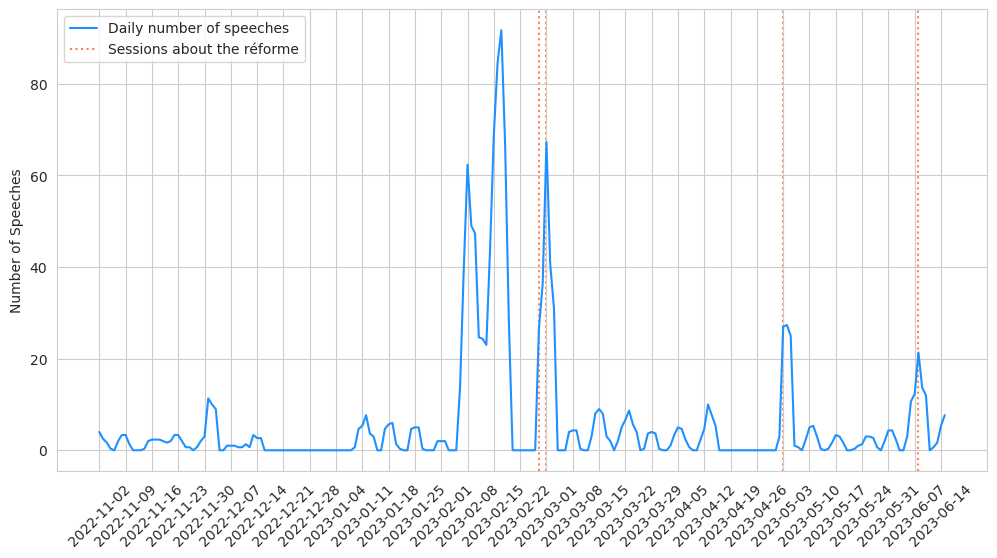

In [5]:
df_parl.reset_index(inplace=True)

# Convert the 'dateSeance' column to a datetime data type if not already done
df_parl['dateSeance'] = pd.to_datetime(df_parl['dateSeance'])

# Set 'dateSeance' as the index
df_parl.set_index('dateSeance', inplace=True)

# Group by Day and count speeches
df_grouped = df_parl.resample('D').size()

# Reindex the DataFrame with a daily frequency and fill missing values with 0
df_grouped = df_grouped.reindex(pd.date_range(df_grouped.index.min(), df_grouped.index.max(), freq='D'), fill_value=0)

# Set up a larger figure
plt.figure(figsize=(12, 6))

# Plot time series with rolling average
plt.plot(df_grouped.index.astype(str), df_grouped.rolling(window=3, min_periods=1).mean(), label='Number of Speeches', color='dodgerblue')
plt.ylabel('Number of Speeches')
plt.legend()

plt.xticks(df_grouped.index.astype(str)[::7], rotation=45)

for date in ['2023-05-03', '2023-02-27', '2023-03-01', '2023-06-08']:
   plt.axvline(x=date, color='coral', linestyle=':', zorder=0)

plt.legend(labels=['Daily number of speeches', "Sessions about the réforme"])
plt.show()

### Media

In [6]:
# Import data
df_selectedmedia = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/GDELT_221001_selectedmedia_Dec23.csv')
df_selectedmedia['DATE'] = pd.to_datetime(df_selectedmedia['DATE'])
df_selectedmedia.shape

(10141, 12)

In [7]:
df_selected_filt = df_selectedmedia[(df_selectedmedia['DATE'] > pd.to_datetime('2023-02-01')) & (df_selectedmedia['DATE'] < pd.to_datetime('2023-03-02'))]
df_selected_filt.shape

(1378, 12)

### Merge

In [8]:
df_parl.reset_index(inplace=True)

df_parl_filtered = df_parl[(df_parl['dateSeance'] > pd.to_datetime('2023-02-01')) & (df_parl['dateSeance'] < pd.to_datetime('2023-03-02'))]
df_parl_filtered.shape

(870, 18)

In [9]:
df_parl_text = df_parl_filtered[['dateSeance','TextProcessed','speech']]
df_parl_text.rename(columns={"dateSeance": "Date", "TextProcessed": "TextProcessed", "speech":"Text"}, inplace = True)
df_parl_text['Source'] = 'Parliament'
df_parl_text

/tmp/ipykernel_1310784/1494334164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parl_text.rename(columns={"dateSeance": "Date", "TextProcessed": "TextProcessed", "speech":"Text"}, inplace = True)
/tmp/ipykernel_1310784/1494334164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parl_text['Source'] = 'Parliament'


,Date,TextProcessed,Text,Source
72,2023-02-27 16:00:00,nombre responsable national engager ailleurs c...,Nombre de ses responsables nationaux étant déj...,Parliament
73,2023-02-27 16:00:00,invitation propos liminaire viser brosser vue ...,Merci de cette invitation : mon propos liminai...,Parliament
74,2023-02-27 16:00:00,infiniment intervenant part expérience échange...,Merci infiniment aux trois intervenants pour n...,Parliament
75,2023-02-27 16:00:00,excuser quelqu’ début question entendre intégr...,Vous voudrez bien m’excuser : quelqu’un me par...,Parliament
76,2023-02-27 16:00:00,convenir mettre terme fuite « » – volume inves...,Il conviendrait tout d’abord de mettre un term...,Parliament
...,...,...,...,...
1390,2023-02-17 09:00:00,regretter Oziol répondre réalité répondre poin...,"Vous dites regretter, madame Oziol, que je ne ...",Parliament
1391,2023-02-17 09:00:00,-t actuellement mettre contribution plateforme...,De quoi parle-t-on actuellement ? Du fait de m...,Parliament
1392,2023-02-17 09:00:00,matin subir tunnel interminable amendement ide...,"Depuis ce matin, nous subissons des tunnels in...",Parliament
1393,2023-02-17 09:00:00,France insoumis mémoire court occasion crise s...,La France insoumise a tout de même la mémoire ...,Parliament


In [10]:
df_selectedmedia_text = df_selected_filt[['DATE','TextProcessed','Text']]
df_selectedmedia_text.rename(columns={"DATE": "Date", "TextProcessed": "TextProcessed",'Text':'Text'}, inplace = True)
df_selectedmedia_text['Source'] = 'Media'
df_selectedmedia_text

/tmp/ipykernel_1310784/1379805693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedmedia_text.rename(columns={"DATE": "Date", "TextProcessed": "TextProcessed",'Text':'Text'}, inplace = True)
/tmp/ipykernel_1310784/1379805693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedmedia_text['Source'] = 'Media'


,Date,TextProcessed,Text,Source
380,2023-02-21 21:30:00,pilote chien matin sentir os bras craquer ferm...,Le pilote s'apprêtait à sortir ses chiens comm...,Media
1101,2023-02-13 10:30:00,explicitement lancer ultimatum gouvernement sa...,"Sans le dire explicitement, ils ont lancé un u...",Media
1103,2023-02-05 00:45:00,maire Paris Anne Hidalgo Parti socialiste cont...,"La maire de Paris, Anne Hidalgo (Parti sociali...",Media
1109,2023-02-04 06:15:00,rassemblement plateform Lavera appel organisat...,Rassemblement de salariés de la plateforme pét...,Media
1118,2023-02-08 18:15:00,pdg totalenergie Patrick Paris 8 novembre 2022...,"Le PDG de TotalEnergies, Patrick Pouyanné, à l...",Media
...,...,...,...,...
10119,2023-02-16 16:30:00,semaine gouvernement parlementaire semaine mar...,"Pour une deuxième semaine, la réforme du systè...",Media
10122,2023-02-17 07:30:00,article publier 17 12H30 rentrer dernier marat...,[Article publié le 17 février et mis à jour à ...,Media
10123,2023-02-14 10:15:00,senior lancer entrepreneuriat senior souhaiter...,Pourquoi les seniors se lancent-ils dans l'ent...,Media
10125,2023-02-15 10:15:00,Emmanuel macron pleinement conscient 2027 luir...,Emmanuel Macron est-il pleinement conscient qu...,Media


In [11]:
df_merge = pd.concat([df_parl_text, df_selectedmedia_text])
df_merge

,Date,TextProcessed,Text,Source
72,2023-02-27 16:00:00,nombre responsable national engager ailleurs c...,Nombre de ses responsables nationaux étant déj...,Parliament
73,2023-02-27 16:00:00,invitation propos liminaire viser brosser vue ...,Merci de cette invitation : mon propos liminai...,Parliament
74,2023-02-27 16:00:00,infiniment intervenant part expérience échange...,Merci infiniment aux trois intervenants pour n...,Parliament
75,2023-02-27 16:00:00,excuser quelqu’ début question entendre intégr...,Vous voudrez bien m’excuser : quelqu’un me par...,Parliament
76,2023-02-27 16:00:00,convenir mettre terme fuite « » – volume inves...,Il conviendrait tout d’abord de mettre un term...,Parliament
...,...,...,...,...
10119,2023-02-16 16:30:00,semaine gouvernement parlementaire semaine mar...,"Pour une deuxième semaine, la réforme du systè...",Media
10122,2023-02-17 07:30:00,article publier 17 12H30 rentrer dernier marat...,[Article publié le 17 février et mis à jour à ...,Media
10123,2023-02-14 10:15:00,senior lancer entrepreneuriat senior souhaiter...,Pourquoi les seniors se lancent-ils dans l'ent...,Media
10125,2023-02-15 10:15:00,Emmanuel macron pleinement conscient 2027 luir...,Emmanuel Macron est-il pleinement conscient qu...,Media


## Topic modeling

In [12]:
documents = df_merge['TextProcessed'].to_list()
documents = [doc.lower() for doc in documents]
print('The number of documents is: '+str(len(documents)))

The number of documents is: 2248


In [13]:
# Initialize variables which will be used later
n_features = 5000
n_components = 40 
n_top_words = 10 

In [14]:
# Create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5,  
    max_features=n_features, 
    ngram_range=(1, 1))

tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

In [15]:
# Perform NMF
seed = 30
nmf = NMF(n_components=n_components, 
          random_state=seed, # Pass an int for reproducible results across multiple function calls.
          alpha_W=0, # Constant that multiplies the regularization terms of W. Set it to zero (default) to have no regularization on W
          l1_ratio=0, # The regularization mixing parameter 0-1. l1_ratio = 0, penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
          max_iter=1000,
          init='random'
          ).fit(tfidf_matrix)

In [16]:
def plot_top_words(model, feature_names, n_top_words, title, name, n_topics, n_seed):
    fig, axes = plt.subplots(5, 8, figsize=(40, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=50)

    plt.subplots_adjust(top=0.93, bottom=0.05, wspace=0.7, hspace=0.2)
    #plt.savefig('./figures/'+str(name)+'_topics'+str(n_topics)+'_seed'+str(n_seed)+'.png')
    plt.show()

In [17]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

#plot_top_words(
#    nmf, tfidf_feature_names, n_top_words, "Topics in merged documents (NMF)", 'scikit_custParlSW_5kFeat', n_components, seed)

In [18]:
# Get the feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 3 indices for each topic
top_indices = nmf.components_.argsort()[:,-5:]

# Create empty list to store top words  
top_words = []

# Loop through each topic
for topic in top_indices:
  
  # Extract top 3 words
  top_3 = [feature_names[i] for i in topic]
  
  # Add to list
  top_words.extend(top_3)

In [19]:
# Get the document-topic matrix
doc_topic_matrix = nmf.transform(tfidf_matrix)

# Calculate topic frequencies across corpus
topic_freqs = doc_topic_matrix.sum(axis=0) 

# Get top 3 words for each topic
top_word_indices = nmf.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Combine topics and top words
topics_with_words = list(zip(topic_freqs, top_words))

# Sort by frequency
sorted_topics = sorted(topics_with_words, key=lambda x: x[0], reverse=False)

# Extract sorted freqs and topic names  
sorted_freqs, sorted_top_words = zip(*sorted_topics)

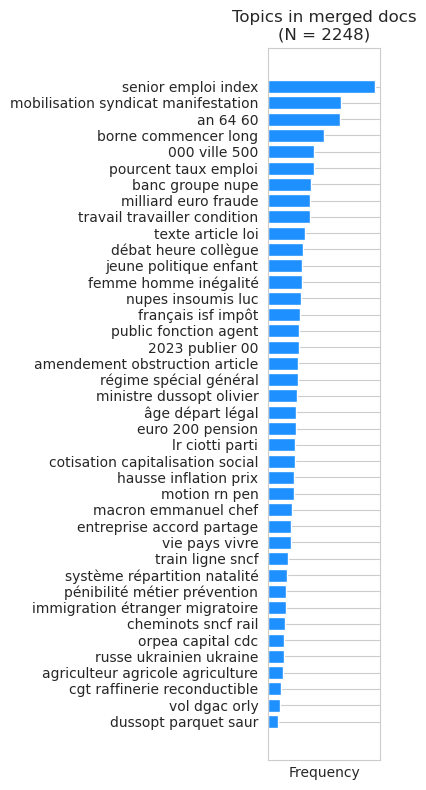

In [20]:
# Plot sorted topics and freqs  
fig, ax = plt.subplots(figsize=(4, 8)) 

# Plot horizontal bars
ax.barh(range(n_components), sorted_freqs, color='dodgerblue')

# Set y-ticks and labels
ax.set_yticks(range(n_components)) 
ax.set_yticklabels(sorted_top_words)

# Remove x-axis tick labels  
ax.set_xticks([]) 

# Axis labels
ax.set_xlabel("Frequency")

# Title and tight layout
ax.set_title(f"Topics in merged docs\n(N = {len(doc_topic_matrix)})")
plt.tight_layout()
plt.show()

#fig.savefig(os.path.join('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/undersampling_plots', f'{timestamp_str}_topicdistribution.png'))

In [21]:
doc_topic_matrix_with_source = np.column_stack((doc_topic_matrix, df_merge["Source"]))

In [22]:
media_vector = np.mean(doc_topic_matrix_with_source[df_merge["Source"] == "Media"][:, :-1], axis=0)
parliament_vector = np.mean(doc_topic_matrix_with_source[df_merge["Source"] == "Parliament"][:, :-1], axis=0)

In [23]:
# Extract the top three words for each topic
top_word_indices = nmf.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Set the column names while creating the DataFrame
df_corporacomparison = pd.DataFrame([media_vector, parliament_vector],columns=top_words, index=['Media', 'Parliament'])

df_corporacomparison

,borne commencer long,senior emploi index,mobilisation syndicat manifestation,train ligne sncf,milliard euro fraude,régime spécial général,an 64 60,dussopt parquet saur,amendement obstruction article,entreprise accord partage,...,français isf impôt,immigration étranger migratoire,vol dgac orly,hausse inflation prix,pourcent taux emploi,000 ville 500,orpea capital cdc,ministre dussopt olivier,texte article loi,pénibilité métier prévention
Media,0.022500,0.022598,0.032575,0.008211,0.012624,0.000486,0.023509,0.004112,0.007748,0.007568,...,0.001833,0.002126,0.005046,0.010691,0.016644,0.014205,0.006094,0.012079,0.013661,0.000979
Parliament,0.005502,0.042070,0.001655,0.001497,0.010715,0.020787,0.015012,0.000541,0.009783,0.004522,...,0.020645,0.009695,0.001014,0.002283,0.006989,0.011288,0.001916,0.002028,0.005259,0.011628


In [24]:
# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media'] - df_corpcomp_T['Parliament'])*100/(df_corpcomp_T['Media'].max() + df_corpcomp_T['Parliament'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

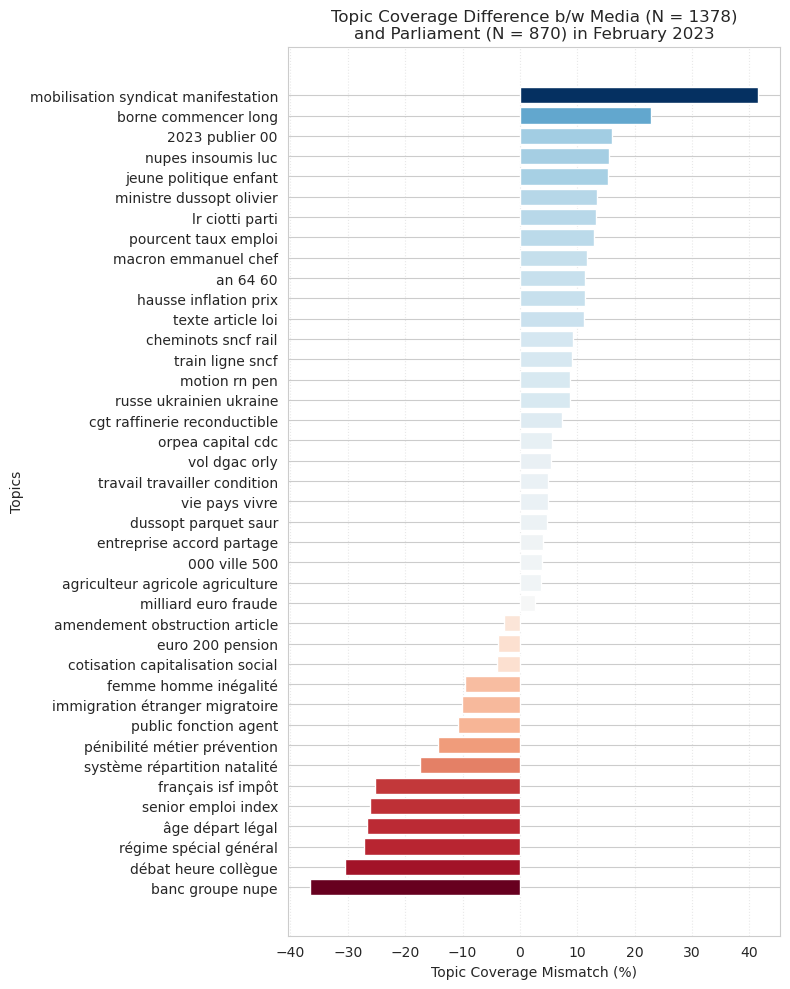

In [25]:
# Plot the data
fig = plt.figure(figsize=(8, 10)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.RdBu(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage Mismatch (%)')
plt.ylabel('Topics')
plt.title(f'Topic Coverage Difference b/w Media (N = {len(df_selectedmedia_text)})\nand Parliament (N = {len(df_parl_text)}) in February 2023')

# Add light grey grid
ax.grid(axis='x', linestyle=':', alpha=0.5, color='lightgrey', zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges